# HW6: Support Vector Machines

In this exercise, you will be using support vector machines (SVMs) to build a spam classifier. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

To get started with the exercise, you will need to download the starter code and unzip its contents to the directory where you wish to complete the exercise. If needed, use the cd command in Octave/MATLAB to change to this directory before starting this exercise.

You can also find instructions for installing Octave/MATLAB in the “Environment Setup Instructions” of the course website.

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import scipy.io
import random
from IPython.display import display, Math, Latex

# set path
import os
os.chdir('%s/courses/coursera_ml008/hw6' % os.getenv('DST'))
print(os.getcwd())

# printing options 
np.set_printoptions(linewidth=250)
np.set_printoptions(precision=3)

# plotting options
%matplotlib inline
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)
plt.rc('figure', figsize=(10, 8))

C:\Users\J28976\Documents\Development\dst\courses\coursera_ml008\hw6


## 1 Support Vector Machines

In the first half of this exercise, you will be using support vector machines (SVMs) with various example 2D datasets. Experimenting with these datasets will help you gain an intuition of how SVMs work and how to use a Gaussian kernel with SVMs. In the next half of the exercise, you will be using support vector machines to build a spam classifier.

The provided script, ex6.m, will help you step through the first half of the exercise.

### 1.1 Example Dataset 1


We will begin by with a 2D example dataset which can be separated by a linear boundary. The script ex6.m will plot the training data (Figure 1). In this dataset, the positions of the positive examples (indicated with +) and the negative examples (indicated with o) suggest a natural separation indicated by the gap. However, notice that there is an outlier positive example + on the far left at about (0.1, 4.1). As part of this exercise, you will also see how this outlier affects the SVM decision boundary.

<img src="fig1.png" width=500/>

In this part of the exercise, you will try using different values of the $C$ parameter with SVMs. Informally, the $C$ parameter is a positive value that controls the penalty for misclassified training examples. A large $C$ parameter tells the SVM to try to classify all the examples correctly. $C$ plays a role similar to 1, where $\lambda$ is the regularization parameter that we were using $\lambda$ previously for logistic regression.

<img src="fig2.png" width=700/>
<img src="fig3.png" width=750/>

The next part in ex6.m will run the SVM training (with $C = 1$) using SVM software that we have included with the starter code, svmTrain.m When $C = 1$, you should find that the SVM puts the decision boundary in the gap between the two datasets and misclassifies the data point on the far left (Figure 2).

Your task is to try different values of $C$ on this dataset. Specifically, you should change the value of $C$ in the script to $C = 100$ and run the SVM training again. When $C = 100$, you should find that the SVM now classifies every single example correctly, but has a decision boundary that does not appear to be a natural fit for the data (Figure 3).

In [2]:
ex6data1 = scipy.io.loadmat('ex6data1.mat')
X = np.asarray(ex6data1['X'])
y = np.asarray(ex6data1['y'].ravel())
X.shape, y.shape

((51L, 2L), (51L,))

In [3]:
def display_data(X, y, boundary=None):
    pos = y==1
    neg = np.logical_not(pos)
    plt.scatter(X[pos,0], X[pos,1], c='k', marker='+', s=50)
    plt.scatter(X[neg,0], X[neg,1], c='y', marker='o', s=50)
    plt.axis([0, 5, 1, 5])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(['positive', 'negative'], loc='lower left')
    
    if boundary is not None:
        xp, yp = boundary
        plt.plot(xp, yp, 'b-')
    plt.show()
 

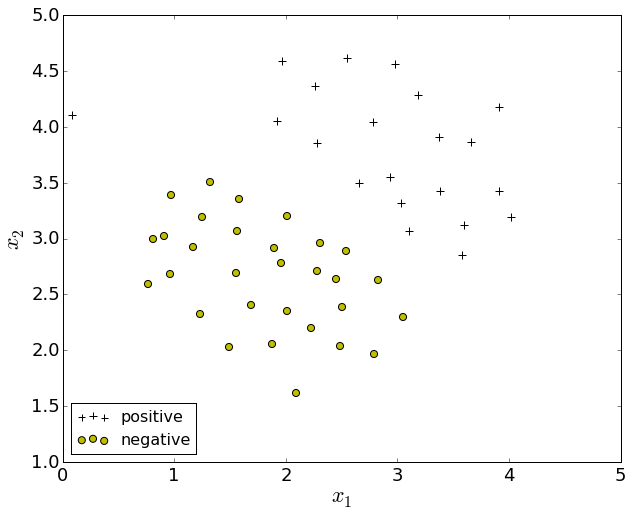

In [4]:
display_data(X, y)

#### fit using SVM

In [5]:
# Import datasets, classifiers and performance metrics
from sklearn import svm

In [6]:
classifier = svm.SVC(C=1.0, kernel='linear')
classifier

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [7]:
classifier.fit(X, y)
classifier

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [8]:
def get_boundary(classifier):
    w = classifier.dual_coef_.dot(classifier.support_vectors_).flatten()
    xp = np.linspace(0, 5, 100)
    yp = (-w[0]*xp - classifier.intercept_)/w[1]
    return xp, yp    

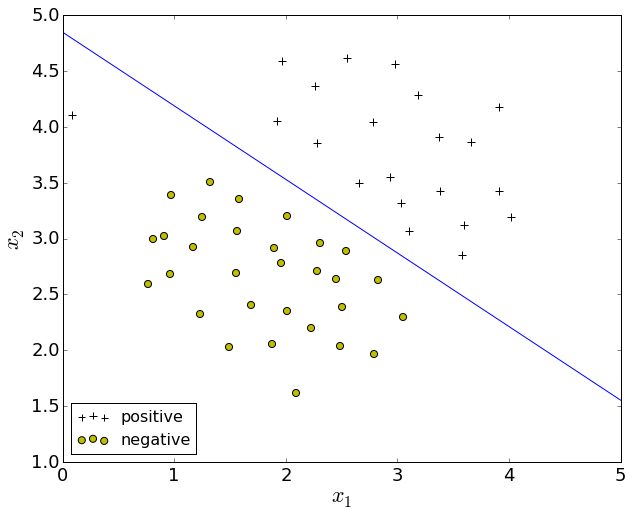

In [9]:
display_data(X, y, get_boundary(classifier))

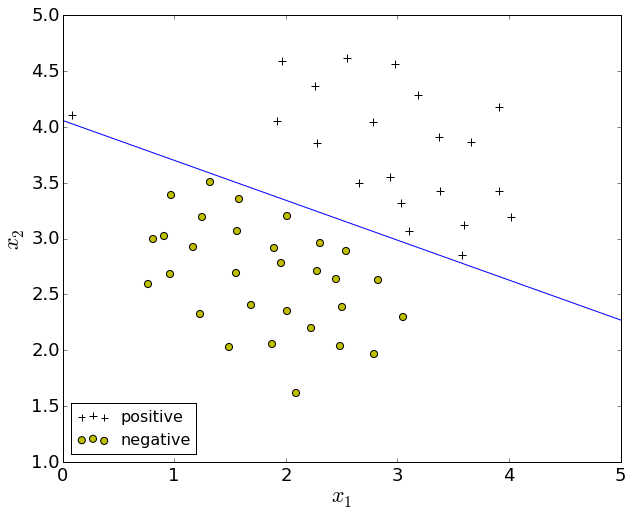

In [10]:
classifier = svm.SVC(C=100.0, kernel='linear')
classifier.fit(X, y)
display_data(X, y, get_boundary(classifier))

### 1.2 SVM with Gaussian Kernels

In this part of the exercise, you will be using SVMs to do non-linear classification. In particular, you will be using SVMs with Gaussian kernels on datasets that are not linearly separable.

#### 1.2.1 Gaussian Kernel

To finnd non-linear decision boundaries with the SVM, we need to first implement a Gaussian kernel. You can think of the Gaussian kernel as a similarity function that measures the "distance" between a pair of examples, $(x^{(i)}, x^{(j)})$. The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.

You should now complete the code in `gaussianKernel.m` to compute the Gaussian kernel between two examples, $(x^{(i)}, x^{(j)})$. The Gaussian kernel function is defined as:

\begin{align}
K_{gaussian}(x^{(i)}, x^{(j)}) 
= \exp\left( -\frac{\|x^{(i)} - x^{(j)}\|^2}{2\sigma^2}\right)
= \exp\left( -\frac{\sum^n_{k=1} \left(x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2}\right)
\end{align}

Once you've completed the function `gaussianKernel.m`, the script `ex6.m` will test your kernel function on two provided examples and you should expect to see a value of 0.324652.

In [11]:
def gaussian_kernel(xi, xj, sigma):
#     print(xi, xj)
    xi    = np.asarray(xi, dtype=np.float)
    xj    = np.asarray(xj, dtype=np.float)
    assert xi.shape==xj.shape, "shapes must be the same"
    
    sigma = float(sigma)
#     return np.exp(-np.sum((xi-xj)**2, axis=1)/(2*sigma**2))
    return np.exp(-np.sum((xi-xj)**2)/(2*sigma**2))

In [12]:
x1    = np.array([1, 2, 1]).reshape(3,1)
x2    = np.array([0, 4, -1]).reshape(3,1)
sigma = 2
gaussian_kernel(x1, x2, sigma)

0.32465246735834974

In [13]:
gaussian_kernel(X, X, sigma)

1.0

#### 1.2.1 Example Dataset 2

The next part in `ex6.m` will load and plot dataset 2 (Figure 4). From the figure, you can observe that there is no linear decision boundary that separates the positive and negative examples for this dataset. However, by using the Gaussian kernel with the SVM, you will be able to learn a non-linear decision boundary that can perform reasonably well for the dataset.

In [14]:
ex6data2 = scipy.io.loadmat('ex6data2.mat')
X = np.asarray(ex6data2['X'])
y = np.asarray(ex6data2['y'].ravel())
X.shape, y.shape

((863L, 2L), (863L,))

In [15]:
def display_data(X, y, boundary=None):
    pos = y==1
    neg = np.logical_not(pos)
    plt.scatter(X[pos,0], X[pos,1], c='k', marker='+', s=50)
    plt.scatter(X[neg,0], X[neg,1], c='y', marker='o', s=50)
    plt.axis([0, 1, 0.4, 1])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(['positive', 'negative'], loc='lower left')
    
#     if boundary is not None:
#         xp, yp = boundary
#         plt.plot(xp, yp, 'b-')
    plt.show()

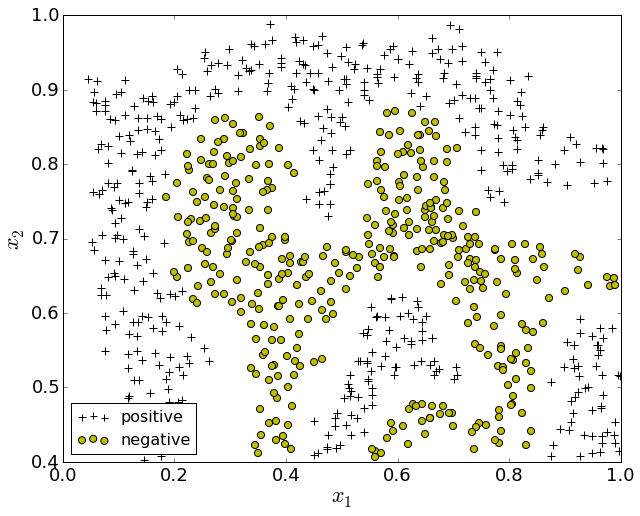

In [16]:
display_data(X, y)

If you have correctly implemented the Gaussian kernel function, `ex6.m` will proceed to train the SVM with the Gaussian kernel on this dataset. Figure 5 shows the decision boundary found by the SVM with a Gaussian kernel. The decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well.

In [17]:
sigma    = 0.01
C        = 1.0
gaus_svm = svm.SVC(C=C, kernel='rbf', gamma=1.0/sigma)
gaus_svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=100.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [18]:
gaus_svm.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=100.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [19]:
def get_boundary(gaus_svm):
    x1plot = np.linspace(0, 1, 100)
    x2plot = np.linspace(0, 1, 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)
    vals   = np.zeros_like(X1)
    for i in np.arange(X1.shape[1]):
        Xi_grid    = np.c_[X1[:,i], X2[:,i]]
        vals[:, i] = gaus_svm.predict(Xi_grid)
    
    return X1, X2, vals

In [20]:
def display_data(X, y, boundary=None):
    pos = y==1
    neg = np.logical_not(pos)
    plt.scatter(X[pos,0], X[pos,1], c='k', marker='+', s=50)
    plt.scatter(X[neg,0], X[neg,1], c='y', marker='o', s=50)
    plt.axis([0, 1, 0.4, 1])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(['positive', 'negative'], loc='lower left')
    
    if boundary is not None:
        X1, X2, vals = boundary
        plt.contour( X1, X2, vals, colors='blue' )

    plt.show()

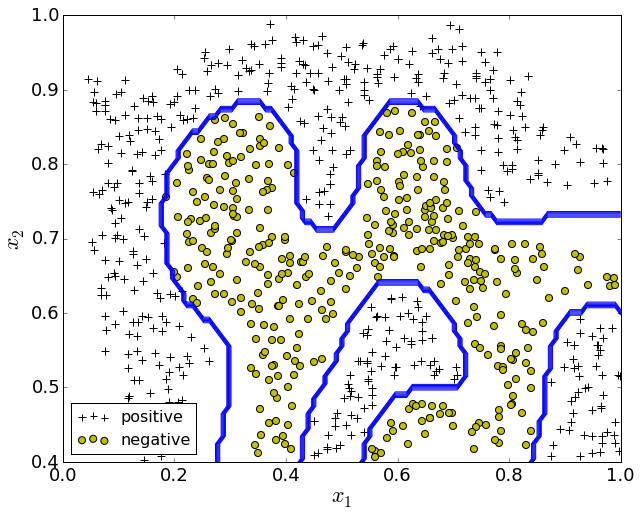

In [21]:
display_data(X, y, get_boundary(gaus_svm))

Figure 5 shows the decision boundary found by the SVM with a Gaussian kernel. The decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well. 

#### trying my own kernal (not working...)

In [22]:
# sigma    = 0.01
# C        = 1.0

# def gaussian_kernel_wrapper(xi, xj):
#     return gaussian_kernel(xi, xj, sigma=sigma)

In [23]:
# gaussian_kernel_wrapper(X, X)

In [24]:
# gaus_svm = svm.SVC(C=C, kernel=gaussian_kernel_wrapper)
# gaus_svm.fit(X, y)

#### 1.2.3 Example Dataset 3

In this part of the exercise, you will gain more practical skills on how to use a SVM with a Gaussian kernel. The next part of `ex6.m` will load and display a third dataset (Figure 6). You will be using the SVM with the Gaussian kernel with this dataset.

In the provided dataset, ex6data3.mat, you are given the variables X, y, Xval, yval. The provided code in ex6.m trains the SVM classifier using the training set $(X, y)$ using parameters loaded from `dataset3Params.m`.

Your task is to use the cross validation set Xval, yval to determine the best C and  parameter to use. You should write any additional code necessary to help you search over the parameters C and . For both C and $\sigma$, we suggest trying values in multiplicative steps (e.g., 0.01; 0.03; 0.1; 0.3; 1; 3; 10; 30). Note that you should try all possible pairs of values for C and  (e.g., C = 0.3 and  = 0.1). For example, if you try each of the 8 values listed above for C and for 2, you would end up training and evaluating (on the cross validation set) a total of $8^2 = 64$ different models.

After you have determined the best C and  parameters to use, you should modify the code in dataset3Params.m, filling in the best parameters you found. For our best parameters, the SVM returned a decision boundary
shown in Figure 7.

In [25]:
ex6data3 = scipy.io.loadmat('ex6data3.mat')
X_train = np.asarray(ex6data3['X'])
y_train = np.asarray(ex6data3['y'].ravel())
X_valid = np.asarray(ex6data3['Xval'])
y_valid = np.asarray(ex6data3['yval'].ravel())
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((211L, 2L), (211L,), (200L, 2L), (200L,))

In [26]:
def get_boundary(gaus_svm):
    x1plot = np.linspace(-0.6,  0.3, 100)
    x2plot = np.linspace(-0.8,  0.6, 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)
    vals   = np.zeros_like(X1)
    for i in np.arange(X1.shape[1]):
        Xi_grid    = np.c_[X1[:,i], X2[:,i]]
        vals[:, i] = gaus_svm.predict(Xi_grid)
    
    return X1, X2, vals

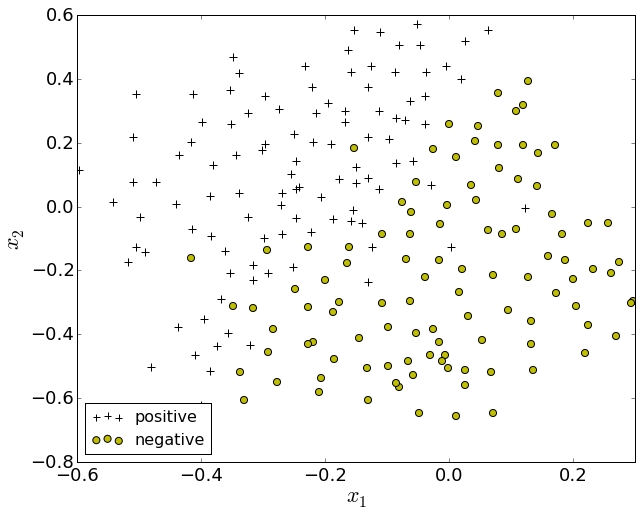

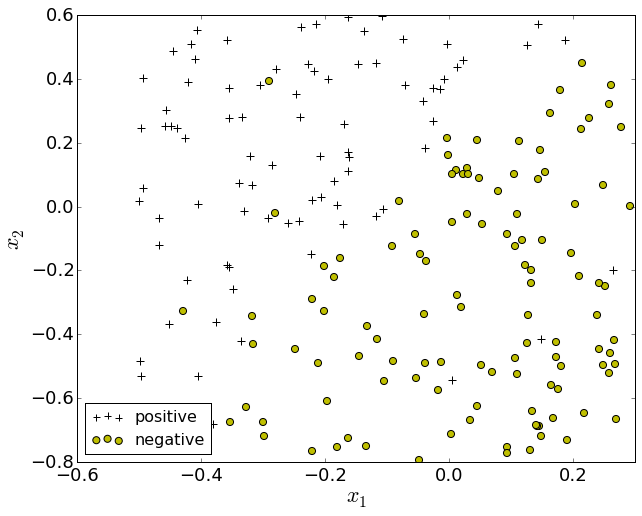

In [27]:
def display_data(X, y, boundary=None):
    pos = y==1
    neg = np.logical_not(pos)
    plt.scatter(X[pos,0], X[pos,1], c='k', marker='+', s=50)
    plt.scatter(X[neg,0], X[neg,1], c='y', marker='o', s=50)
    plt.axis([-0.6, 0.3, -0.8, 0.6])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(['positive', 'negative'], loc='lower left')
    
    if boundary is not None:
        X1, X2, vals = boundary
        plt.contour( X1, X2, vals, colors='blue' )

    plt.show()

display_data(X_train, y_train)
display_data(X_valid, y_valid)

In [28]:
C     = 1.0
sigma = 0.01

gaus_svm = svm.SVC(C=C, kernel='rbf', gamma=1.0/sigma)
gaus_svm.fit(X_train, y_train)
pred_train = gaus_svm.predict(X_train)
acc_train  = np.mean(pred_train==y_train)
pred_valid = gaus_svm.predict(X_valid)
acc_valid  = np.mean(pred_valid==y_valid)
acc_valid, acc_train

(0.96499999999999997, 0.94312796208530802)

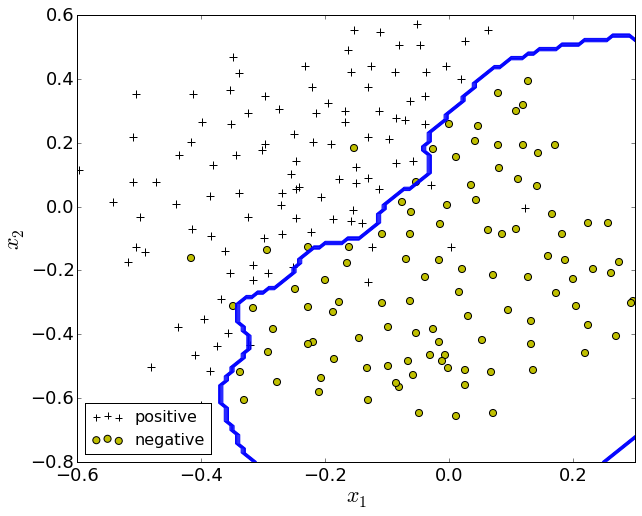

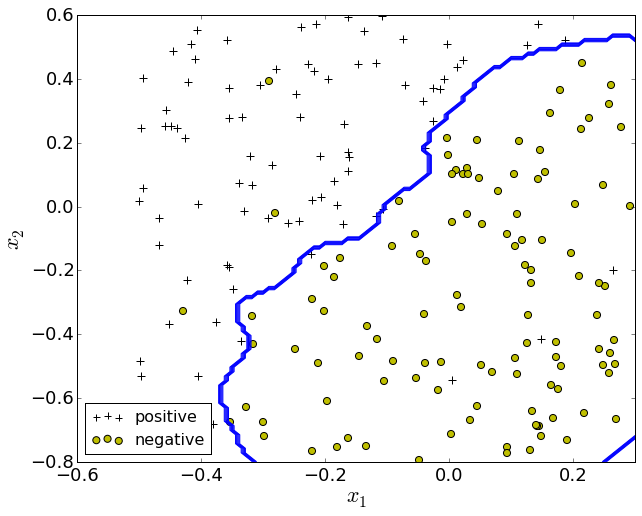

In [29]:
display_data(X_train, y_train, get_boundary(gaus_svm))
display_data(X_valid, y_valid, get_boundary(gaus_svm))

In [30]:
def get_accurancy(X_train, y_train, X_valid, y_valid, C, sigma):
    
    gaus_svm = svm.SVC(C=C, kernel='rbf', gamma=1.0/sigma)
    gaus_svm.fit(X_train, y_train)
    pred_train = gaus_svm.predict(X_train)
    acc_train  = np.mean(pred_train==y_train)
    pred_valid = gaus_svm.predict(X_valid)
    acc_valid  = np.mean(pred_valid==y_valid)
    return acc_valid, acc_train

In [31]:
get_accurancy(X_train, y_train, X_valid, y_valid, C, sigma)

(0.96499999999999997, 0.94312796208530802)

In [32]:
Cs     = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])
sigmas = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])

df = pd.DataFrame(
    {'C'    : np.empty((len(Cs)*len(sigmas)), dtype=np.float64),
     'sigma': np.empty((len(Cs)*len(sigmas)), dtype=np.float64),
     'val'  : np.empty((len(Cs)*len(sigmas)), dtype=np.float64),
     'train': np.empty((len(Cs)*len(sigmas)), dtype=np.float64),
    }
)

for i, C in enumerate(Cs):
    for j, sigma in enumerate(sigmas):
        acc_valid, acc_train = get_accurancy(X_train, y_train, X_valid, y_valid, C, sigma)
        idx                  = len(sigmas)*i+j
        
        df.iloc[idx]['C'    ] = C
        df.iloc[idx]['sigma'] = sigma
        df.iloc[idx]['val'  ] = acc_valid
        df.iloc[idx]['train'] = acc_train

# df.sort(['val'], inplace=True, ascending=False)
df.set_index(['C', 'sigma'], inplace=True)
df.head()

train    val
C    sigma                
0.01 0.01   0.50237  0.435
     0.03   0.50237  0.435
     0.10   0.50237  0.435
     0.30   0.50237  0.435
     1.00   0.50237  0.435

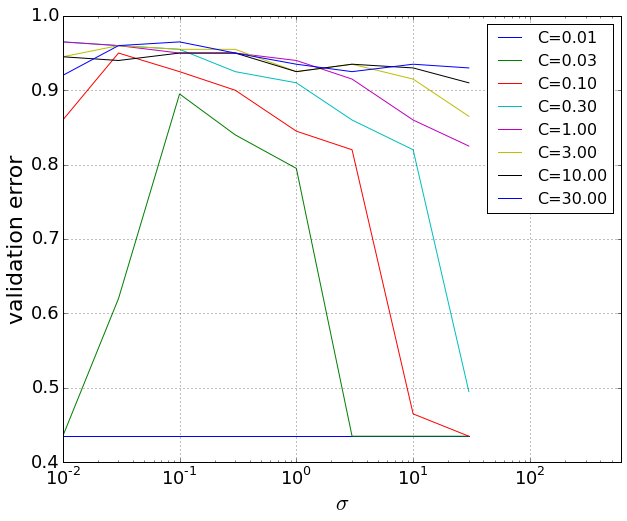

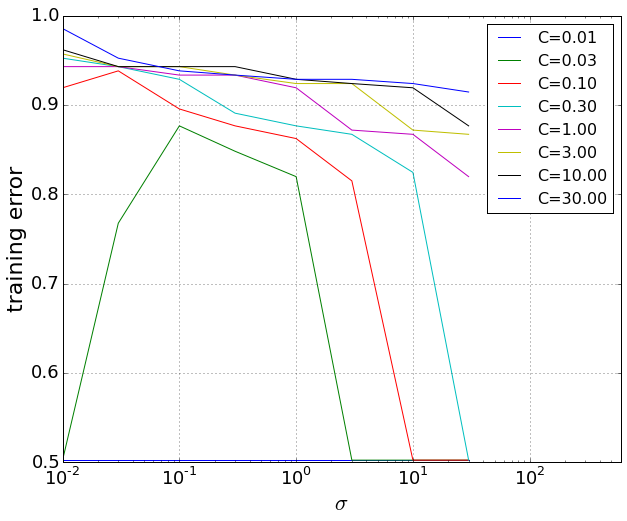

In [33]:
def plot_error(df, field):
    idx    = pd.IndexSlice
    legend = []
    for C in Cs:
        sub_df = df.loc[idx[C, :],:]
        ss = sub_df.index.levels[1]
        plt.plot(ss, sub_df[field])
        plt.xscale('log')
        legend.append('C=%1.2f'%C)
    plt.legend(legend)
    plt.xlabel(r'$\sigma$')
    plt.xlim((min(sigmas), 20*max(sigmas)))
    if field=='val':
        plt.ylabel('validation error')
    else:
        plt.ylabel('training error')
    plt.grid()
    plt.show()
    
plot_error(df, 'val'  )
plot_error(df, 'train')

In [34]:
df[df.val==max(df.val)]

,,train,val
C,sigma,,
0.3,0.01,0.952607,0.965
1.0,0.01,0.943128,0.965
30.0,0.10,0.938389,0.965


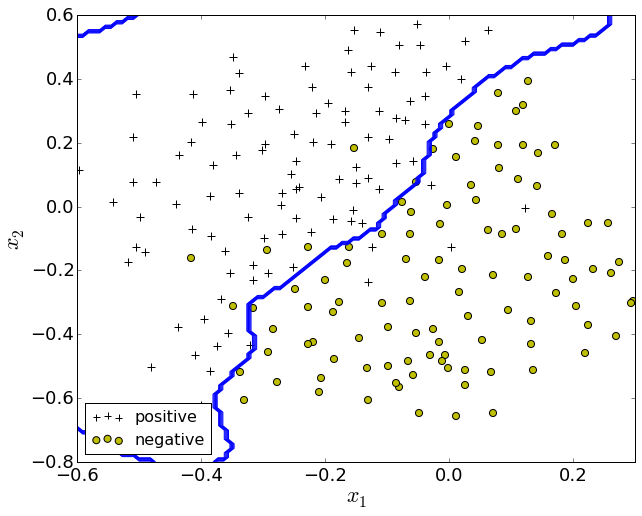

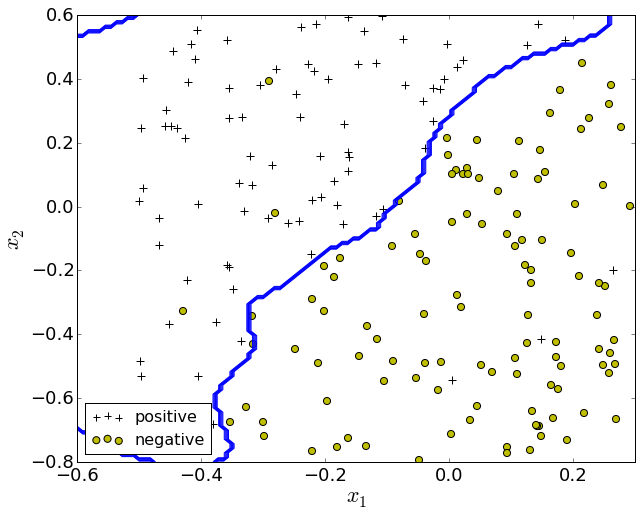

In [35]:
C     = 0.3
sigma = 0.01

gaus_svm = svm.SVC(C=C, kernel='rbf', gamma=1.0/sigma)
gaus_svm.fit(X_train, y_train)
pred_train = gaus_svm.predict(X_train)
acc_train  = np.mean(pred_train==y_train)
pred_valid = gaus_svm.predict(X_valid)
acc_valid  = np.mean(pred_valid==y_valid)
acc_valid, acc_train

display_data(X_train, y_train, get_boundary(gaus_svm))
display_data(X_valid, y_valid, get_boundary(gaus_svm))

## 2. Spam Classification

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the exercise, you will use SVMs to build your own spam filter.

You will be training a classifier to classify whether a given email, x, is spam (y = 1) or non-spam (y = 0). In particular, you need to convert each email into a feature vector $x \in \Bbb{R}^n$. The following parts of the exercise will walk you through how such a feature vector can be constructed from an
email.

Throughout the rest of this exercise, you will be using the the script `ex6_spam.m`. The dataset included for this exercise is based on a a subset of the `SpamAssassin Public Corpus`.  For the purpose of this exercise, you will
only be using the body of the email (excluding the email headers).

<img src="fig8.png" width=700/>

Before starting on a machine learning task, it is usually insightful to take a look at examples from the dataset. Figure 8 shows a sample email that contains a URL, an email address (at the end), numbers, and dollar amounts. While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specific URL or specific dollar amount) will be difierent in almost every email. Therefore, one method often employed in processing emails is to "normalize" these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the email with the unique string "httpaddr" to indicate that a URL was present. 

This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small.

In `processEmail.m`, we have implemented the following email preprocessing and normalization steps:

 * Lower-casing: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).
 * Stripping HTML: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.
 * Normalizing URLs: All URLs are replaced with the text "httpaddr".
 * Normalizing Email Addresses: All email addresses are replaced with the text "emailaddr".
 * Normalizing Numbers: All numbers are replaced with the text "number".
 * Normalizing Dollars: All dollar signs ($) are replaced with the text "dollar".
 * Word Stemming: Words are reduced to their stemmed form. For example, "discount", "discounts", "discounted" and "discounting" are all replaced with "discount". Sometimes, the Stemmer actually strips off additional characters from the end, so "include", "includes", "included", and "including" are all replaced with "includ".
 * Removal of non-words: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.
 
The result of these preprocessing steps is shown in Figure 9. While preprocessing has left word fragments and non-words, this form turns out to be much easier to work with for performing feature extraction.

<img src="fig9.png" width=700/>

#### 2.1.1 Vocabulary List

After preprocessing the emails, we have a list of words (e.g., Figure 9) for each email. The next step is to choose which words we would like to use in our classifier and which we would want to leave out.

For this exercise, we have chosen only the most frequently occuring words as our set of words considered (the vocabulary list). Since words that occur rarely in the training set are only in a few emails, they might cause the model to overfit our training set. The complete vocabulary list is in the file `vocab.txt` and also shown in Figure 10. Our vocabulary list was selected by choosing all words which occur at least a 100 times in the spam corpus, resulting in a list of 1899 words. In practice, a vocabulary list with about 10,000 to 50,000 words is often used.

Given the vocabulary list, we can now map each word in the preprocessed emails (e.g., Figure 9) into a list of word indices that contains the index of the word in the vocabulary list. Figure 11 shows the mapping for the sample email. Specifically, in the sample email, the word "anyone" was first normalized to "anyon" and then mapped onto the index 86 in the vocabulary list.

Your task now is to complete the code in `processEmail.m` to perform this mapping. In the code, you are given a string str which is a single word from the processed email. You should look up the word in the vocabulary list vocabList and find if the word exists in the vocabulary list. If the word exists, you should add the index of the word into the word indices variable. If the word does not exist, and is therefore not in the vocabulary, you can
skip the word.

Once you have implemented `processEmail.m`, the script `ex6_spam.m` will run your code on the email sample and you should see an output similar to Figures 9 & 11.

In [36]:
email_contents = open('emailSample1.txt', 'r').read()
print(email_contents)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




In [37]:
def get_vocab_df():
    df = pd.read_csv('vocab.txt', sep='\t', names=['idx', 'word'])
    df.set_index('word', inplace=True)
    return df
    #result = df.idx.to_dict()
    #del(df)
    #return result

In [38]:
def process_email(email_contents):
    
    import re
    import nltk.stem.porter
    
    # vocab list
    vocab_dict = get_vocab_df().idx.to_dict()
    
    # -------------------------- #
    # lower case
    # -------------------------- #
    
    email_contents = email_contents.lower()
    
    # -------------------------- #
    # strip HTML
    # -------------------------- #
    
    # look for any expression that starts with < and ends with > and replace
    # and does not have any < or > in the tag it with a space
    email_contents = re.sub(r'<[^<>]+>', ' ', email_contents)
    
    # -------------------------- #
    # handle numbers
    # -------------------------- #
    
    # remove characters between 0-9
    email_contents = re.sub(r'[0-9]+', 'number', email_contents)
    
    # -------------------------- #
    # Handle URLS
    # -------------------------- #

    # Look for strings starting with http:// or https://
    email_contents = re.sub(r'(http|https)://[^\s]*', 'httpaddr', email_contents)
    
    # -------------------------- #
    # Handle Email Addresses
    # -------------------------- #

    # Look for strings with @ in the middle
    email_contents = re.sub(r'[^\s]+@[^\s]+', 'emailaddr', email_contents)
    
    # -------------------------- #
    # Handle $ sign
    # -------------------------- #

    email_contents = re.sub(r'[$]+', 'dollar', email_contents)
    
    # -------------------------- #
    # tokenize
    # -------------------------- #
    
    stemmer = nltk.stem.porter.PorterStemmer()
    tokens  = re.split( '[ ' + re.escape("@$/#.-:&*+=[]?!(){},'\">_<;%") + ']', email_contents)
    word_indices = []
    for token in tokens:
        token = re.sub('[^a-zA-Z0-9]', '', token)
        token = stemmer.stem(token.strip())
        if len(token)==0:
            continue
        
        if token in vocab_dict:
            word_indices.append(vocab_dict[token])
          
    return word_indices

In [39]:
print(process_email(email_contents))

[86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1893, 1364, 592, 1676, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 479, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699, 531]


### 2.2 Extracting Features from Emails

You will now implement the feature extraction that converts each email into a vector in $\Bbb{R}^n$. For this exercise, you will be using n = # words in vocabulary list. Specifically, the feature $x_i \in {0,1}$ for an email corresponds to whether the i-th word in the dictionary occurs in the email. That is, $x_i = 1$ if the i-th word is in the email and $x_i = 0$ if the i-th word is not present in the email.

Thus, for a typical email, this feature would look like:

\begin{align}
x = 
\left[
\begin{array}{c}
0      \\
\vdots \\
1      \\
0      \\
\vdots \\
1      \\
0      \\
\vdots \\
0      \\
\end{array} 
\right]
\in \Bbb{R}^n.
\end{align}

You should now complete the code in `emailFeatures.m` to generate a feature vector for an email, given the word indices.

Once you have implemented `emailFeatures.m`, the next part of `ex6_spam.m` will run your code on the email sample. You should see that the feature vector had length 1899 and 45 non-zero entries.

In [40]:
word_indices = process_email(email_contents)
word_indices[0:3]

[86, 916, 794]

In [41]:
def email_features(word_indices):
    df = get_vocab_df()
    df.set_index('idx', inplace=True)
    x = np.zeros(len(df))
    for idx in word_indices:
        x[idx-1] = 1
    return x

In [42]:
x = email_features(word_indices)
x.shape, np.sum(x)

((1899L,), 45.0)

### 2.3 Train SVM for Spam Classification

After you have completed the feature extraction functions, the next step of ex6 spam.m will load a preprocessed training dataset that will be used to train a SVM classifier. `spamTrain.mat` contains 4000 training examples of spam and non-spam email, while `spamTest.mat` contains 1000 test examples. Each original email was processed using the `processEmail` and `emailFeatures` functions and converted into a vector $x^{(i)} \in \Bbb{R}^{1899}$.

After loading the dataset, ex6 spam.m will proceed to train a SVM to classify between spam (y = 1) and non-spam (y = 0) emails. Once the training completes, you should see that the classifier gets a training accuracy of about 99.8% and a test accuracy of about 98.5%.

In [43]:
data = scipy.io.loadmat('spamTrain.mat')
X_train = data['X']
y_train = data['y']
del(data)
X_train.shape, y_train.shape

((4000L, 1899L), (4000L, 1L))

In [44]:
data = scipy.io.loadmat('spamTest.mat')
X_test = data['Xtest']
y_test = data['ytest']
del(data)
X_test.shape, y_test.shape

((1000L, 1899L), (1000L, 1L))

In [45]:
def get_accurancy(X_train, y_train, X_valid, y_valid, C):
    y_train = np.asarray(y_train.ravel(), dtype=np.float32)
    y_valid = np.asarray(y_valid.ravel(), dtype=np.float32)
    
    gaus_svm = svm.SVC(C=C, kernel='linear')
    gaus_svm.fit(X_train, y_train)
    pred_train = gaus_svm.predict(X_train)
    acc_train  = np.mean(pred_train==y_train)
    pred_valid = gaus_svm.predict(X_valid)
    acc_valid  = np.mean(pred_valid==y_valid)
    return acc_valid, acc_train

In [50]:
C = 0.1
train_acc, test_acc = get_accurancy(X_train, y_train, X_test, y_test, C)
train_acc, test_acc

(0.98899999999999999, 0.99824999999999997)

### 2.4 Top Predictors for Spam

To better understand how the spam classifier works, we can inspect the parameters to see which words the classifier thinks are the most predictive of spam. The next step of `ex6_spam.m` finds the parameters with the largest positive values in the classifier and displays the corresponding words (Figure 12). Thus, if an email contains words such as "guarantee", "remove", "dollar", and "price" (the top predictors shown in Figure 12), it is likely to be classified as spam.

<img src="fig12.png" width=700/>

In [51]:
C        = 0.1
gaus_svm = svm.SVC(C=C, kernel='linear')
gaus_svm.fit(X_train, y_train.ravel())
gaus_svm

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [52]:
w = gaus_svm.dual_coef_.dot(gaus_svm.support_vectors_).flatten()
w.shape, w

((1899L,), array([ 0.008,  0.016,  0.055, ..., -0.087, -0.007,  0.065]))

In [53]:
df = get_vocab_df()
df['w'] = w
df.sort('w', ascending=False).head(15)

,idx,w
word,,
our,1191,0.500614
click,298,0.465916
remov,1398,0.422869
guarante,739,0.383622
visit,1796,0.367710
basenumb,156,0.345064
dollar,477,0.323632
will,1852,0.269724
price,1299,0.267298
